In [1]:
# imports
import keras_tuner as kt
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from nnTrain import getSplitData
from selectionPlots import findAllFilesInPath

2023-02-20 11:47:40.286359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 11:47:40.924386: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 11:47:41.091990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/george/root/lib
2023-02-20 11:47:41.092004: I tensorflow/compiler/xla/stream_

Welcome to JupyROOT 6.26/06


/home/george/root/lib/ROOT/_facade.py:153: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


In [2]:
class HyperTuner(kt.HyperModel):
  def build(self, hp):
    model = Sequential()

    for i in range(hp.Int("num_layers", 3, 9)): # Variable number of hidden layers
      model.add(
        Dense(
          units = hp.Int(f"units_{i}", min_value = 4, max_value = 40, step = 2),
          activation = hp.Choice("activation", ["relu", "tanh", "elu"])
        )
      )

    if hp.Boolean("dropout"): # Possible dropout layer to prevent overfitting
      model.add(Dropout(rate = hp.Float("dropout_rate", min_value = 0.1, max_value = 0.9, step = 0.1)))

    model.add(Dense(1, activation = "sigmoid")) # Output layer

    learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")

    # Compile the model
    model.compile(
      loss = "binary_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy"]
    )

    return model

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(
      *args,
      batch_size = hp.Int("batch_size", 32, 128, step = 32),
      **kwargs
    )

In [21]:
sampleNames = findAllFilesInPath("*.root", "nTupleGroups/")
nTupleSamples = dict.fromkeys(sampleNames, 0)
nTupleSamples["nTupleGroups/signalGroup.root"] = 1

# Tuple of variables to get from each file
variables = ["tauPtSum", "zMassSum", "metPt", "deltaRll", "deltaRtt", "deltaRttll", "deltaEtall", "deltaEtatt",
             "nJets", "deltaPhill", "deltaPhitt", "deltaPhilltt", "mmc"]

cut = "3lep"
X_train, X_test, y_train, y_test = getSplitData(nTupleSamples, variables, cut, 0)

In [22]:
# Create the tuner
tuner = kt.Hyperband(HyperTuner(),
                      objective = "val_accuracy",
                      max_epochs = 100,
                      factor = 3,
                      directory = "hyperTuning",
                      project_name = "hyperTuning" + cut,
                      overwrite = True)

stop_early = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True, verbose = 1)

In [23]:
# 0.25*0.8 = 0.2 to get 20% of the data for validation
tuner.search(X_train, y_train, validation_split = 0.25, callbacks = [stop_early])

Trial 254 Complete [00h 00m 13s]
val_accuracy: 0.8331553339958191

Best val_accuracy So Far: 0.8367869853973389
Total elapsed time: 00h 16m 40s
INFO:tensorflow:Oracle triggered exit


In [24]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print("The hyperparameter search is complete (" + cut + "). The optimal number of layers was:", best_hps.get("num_layers"))

for i in range(best_hps.get("num_layers")):
  print("layer", i, ":", best_hps.get(f"units_{i}"), best_hps.get("activation"))

print("Dropout:", best_hps.get("dropout"))
if best_hps.get("dropout"):
  print("Dropout rate:", best_hps.get("dropout_rate"))

print("Learning rate:", best_hps.get("lr"))

print("Batch size:", best_hps.get("batch_size"))

The hyperparameter search is complete (3lep). The optimal number of layers was: 4
layer 0 : 12 elu
layer 1 : 10 elu
layer 2 : 30 elu
layer 3 : 22 elu
Dropout: False
Learning rate: 0.003470122933931012
Batch size: 128


In [36]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

# Save the model architecture without the weights
model.save("nnModels/" + cut + "Model.h5")

history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.25, callbacks = [stop_early])

Epoch 1/100
439/439 [==============================] - 1s 2ms/step - loss: 0.4540 - accuracy: 0.7966 - val_loss: 0.4217 - val_accuracy: 0.8233
Epoch 2/100
439/439 [==============================] - 1s 2ms/step - loss: 0.4112 - accuracy: 0.8234 - val_loss: 0.4079 - val_accuracy: 0.8295
Epoch 3/100
439/439 [==============================] - 1s 2ms/step - loss: 0.4030 - accuracy: 0.8249 - val_loss: 0.4057 - val_accuracy: 0.8291
Epoch 4/100
439/439 [==============================] - 1s 2ms/step - loss: 0.3987 - accuracy: 0.8278 - val_loss: 0.4073 - val_accuracy: 0.8214
Epoch 5/100
439/439 [==============================] - 1s 2ms/step - loss: 0.3956 - accuracy: 0.8260 - val_loss: 0.3985 - val_accuracy: 0.8282
Epoch 6/100
439/439 [==============================] - 1s 2ms/step - loss: 0.3935 - accuracy: 0.8278 - val_loss: 0.4109 - val_accuracy: 0.8218
Epoch 7/100
439/439 [==============================] - 1s 2ms/step - loss: 0.3921 - accuracy: 0.8308 - val_loss: 0.3986 - val_accuracy: 0.8302

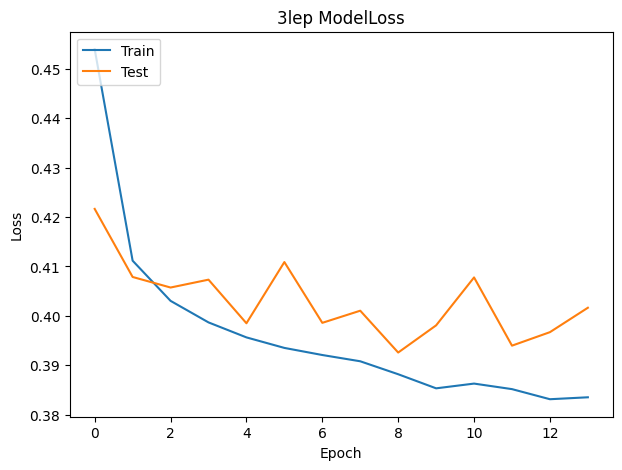

<Figure size 640x480 with 0 Axes>

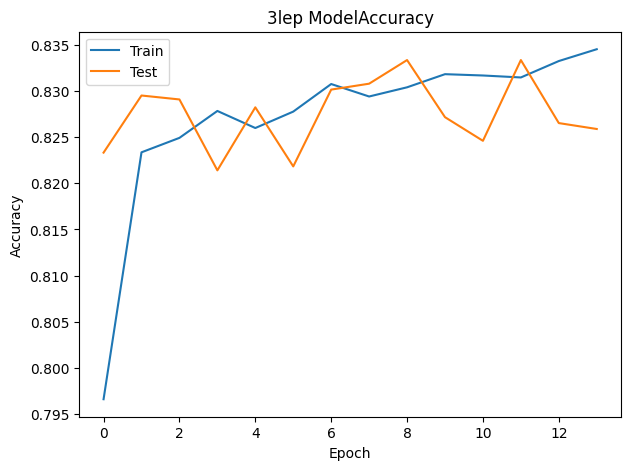

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot the accuracy and loss per epoch
%matplotlib inline
import matplotlib.pyplot as plt
for i in ("loss", "accuracy"):
    plt.figure(figsize = (7, 5))
    plt.plot(history.history[i])
    plt.plot(history.history["val_" + i])
    plt.title(cut + " Model" + i.capitalize())
    plt.ylabel(i.capitalize())
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()
    plt.clf()

In [35]:
# Save the model
model.save("nnModels/hyperTuned" + cut + ".h5")